In [50]:
import pandas as pd
import numpy as np
import recruit_utils

import pdvega
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import statsmodels.api as sm
from statsmodels.graphics.regressionplots import *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, kpss
from sklearn import cluster
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
%matplotlib inline

In [3]:
# Import data into pandas data frames
data, stores = recruit_utils.import_data()

In [4]:
# Transform data and stores into train and test data frames
train, test = recruit_utils.create_train_test(data, stores)

In [5]:
# Inspect the training data
train.head()

,air_store_id,day,dow,id,large_party,log_visitors,month,subset,visit_date,visitors,...,rs2_y,rv2_y,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long,lon_plus_lat,air_store_id2
0,air_00a91d42b08b08d9,1,4,air_00a91d42b08b08d9_2016-07-01,0.0,3.555348,7,train,2016-07-01,35,...,1.0,1.0,-1.0,-1.0,-1.0,20160701,8.326629,4.519803,175.447598,0
1,air_00a91d42b08b08d9,2,5,air_00a91d42b08b08d9_2016-07-02,0.0,2.197225,7,train,2016-07-02,9,...,-1.0,-1.0,-1.0,-1.0,-1.0,20160702,8.326629,4.519803,175.447598,0
2,air_00a91d42b08b08d9,4,0,air_00a91d42b08b08d9_2016-07-04,0.0,2.995732,7,train,2016-07-04,20,...,-1.0,-1.0,-1.0,-1.0,-1.0,20160704,8.326629,4.519803,175.447598,0
3,air_00a91d42b08b08d9,5,1,air_00a91d42b08b08d9_2016-07-05,0.0,3.218876,7,train,2016-07-05,25,...,-1.0,-1.0,-1.0,-1.0,-1.0,20160705,8.326629,4.519803,175.447598,0
4,air_00a91d42b08b08d9,6,2,air_00a91d42b08b08d9_2016-07-06,0.0,3.367296,7,train,2016-07-06,29,...,12.0,7.0,-1.0,-1.0,-1.0,20160706,8.326629,4.519803,175.447598,0


In [6]:
train.shape

(252108, 74)

In [7]:
train.describe()

,day,dow,large_party,log_visitors,month,visitors,wom,year,visitors_lag1,visitors_diff1,...,rs2_y,rv2_y,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long,lon_plus_lat,air_store_id2
count,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,...,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,2.521080e+05,252108.000000,252108.000000,252108.000000,252108.000000
mean,15.591830,3.019678,0.000825,2.706059,6.208200,20.973761,2.678582,2016.307697,2.693014,-0.002592,...,-0.604422,-0.706806,-0.473611,-0.867509,-0.830113,2.016371e+07,8.353065,6.860945,171.835624,412.701513
std,8.670745,1.923985,0.028712,0.907205,3.680263,16.757007,1.251037,0.461542,0.930037,0.896659,...,2.375366,1.620808,4.345131,1.082836,1.478630,4.372124e+03,2.158952,3.706457,14.921842,239.698964
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2016.000000,-1.000000,-5.062595,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.016010e+07,-1.000000,-1.000000,-1.000000,0.000000
25%,8.000000,1.000000,0.000000,2.197225,3.000000,9.000000,2.000000,2016.000000,2.197225,-0.470004,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.016072e+07,8.326629,4.521799,169.985683,205.000000
50%,16.000000,3.000000,0.000000,2.833213,7.000000,17.000000,3.000000,2016.000000,2.833213,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.016102e+07,8.362564,4.601440,175.339634,406.000000
75%,23.000000,5.000000,0.000000,3.367296,10.000000,29.000000,4.000000,2017.000000,3.367296,0.470004,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.017012e+07,9.325508,8.931834,175.442512,623.000000
max,31.000000,6.000000,1.000000,6.776507,12.000000,877.000000,5.000000,2017.000000,6.776507,5.568345,...,90.000000,100.000000,264.000000,62.000000,80.000000,2.017042e+07,10.808664,14.077843,188.294030,828.000000


In [8]:
# Inspect the test data
test.head()

,air_store_id,day,dow,id,large_party,log_visitors,month,subset,visit_date,visitors,...,rs2_y,rv2_y,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long,lon_plus_lat,air_store_id2
0,air_00a91d42b08b08d9,23,6,air_00a91d42b08b08d9_2017-04-23,0.0,0.0,4,test,2017-04-23,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20170423,8.326629,4.519803,175.447598,0
1,air_00a91d42b08b08d9,24,0,air_00a91d42b08b08d9_2017-04-24,0.0,0.0,4,test,2017-04-24,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20170424,8.326629,4.519803,175.447598,0
2,air_00a91d42b08b08d9,25,1,air_00a91d42b08b08d9_2017-04-25,0.0,0.0,4,test,2017-04-25,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20170425,8.326629,4.519803,175.447598,0
3,air_00a91d42b08b08d9,26,2,air_00a91d42b08b08d9_2017-04-26,0.0,0.0,4,test,2017-04-26,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20170426,8.326629,4.519803,175.447598,0
4,air_00a91d42b08b08d9,27,3,air_00a91d42b08b08d9_2017-04-27,0.0,0.0,4,test,2017-04-27,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20170427,8.326629,4.519803,175.447598,0


In [9]:
test.shape

(32019, 74)

In [10]:
test.describe()

,day,dow,large_party,log_visitors,month,visitors,wom,year,visitors_lag1,visitors_diff1,...,rs2_y,rv2_y,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long,lon_plus_lat,air_store_id2
count,32019.000000,32019.000000,32019.0,32019.0,32019.000000,32019.0,32019.000000,32019.0,32019.000000,32019.000000,...,32019.000000,32019.000000,32019.000000,32019.000000,32019.000000,3.201900e+04,32019.000000,32019.000000,32019.000000,32019.000000
mean,18.153846,2.923077,0.0,0.0,4.794872,0.0,3.051282,2017.0,0.076243,-0.076243,...,-0.832153,-0.934794,-0.908398,-0.964198,-0.904413,2.017050e+07,8.386876,6.861834,173.045321,413.711328
std,9.090961,2.042964,0.0,0.0,0.403802,0.0,1.319475,0.0,0.492419,0.492419,...,1.933239,0.847254,1.504344,0.574352,1.426836,3.702412e+01,2.058665,3.641456,5.213828,238.827977
min,1.000000,0.000000,0.0,0.0,4.000000,0.0,1.000000,2017.0,0.000000,-4.983607,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.017042e+07,0.000000,0.000000,163.752875,0.000000
25%,10.000000,1.000000,0.0,0.0,5.000000,0.0,2.000000,2017.0,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.017050e+07,8.326629,4.521799,170.079161,208.000000
50%,20.000000,3.000000,0.0,0.0,5.000000,0.0,3.000000,2017.0,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.017051e+07,8.362564,4.588406,175.339634,413.000000
75%,26.000000,5.000000,0.0,0.0,5.000000,0.0,4.000000,2017.0,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.017052e+07,9.325508,8.931834,175.442512,619.000000
max,31.000000,6.000000,0.0,0.0,5.000000,0.0,5.000000,2017.0,4.983607,0.000000,...,53.000000,35.000000,54.000000,27.000000,49.500000,2.017053e+07,10.808664,14.077843,188.294030,828.000000


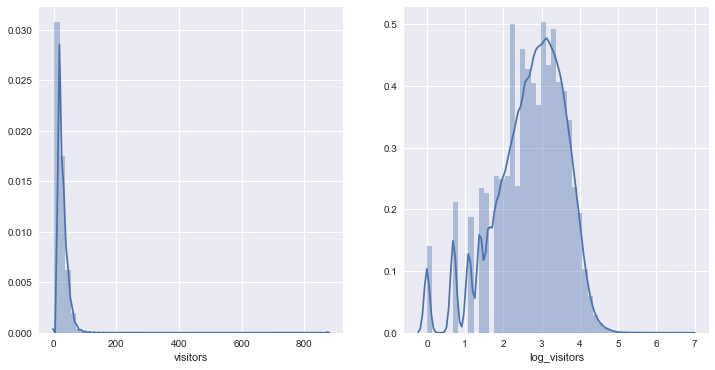

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
sns.distplot(train['visitors'], ax=axs[0])
sns.distplot(train['log_visitors'], ax=axs[1])

In [12]:
# Define list of main predictor variables for visualizations
categorical_vars = ['dow', 'wom', 'year', 'month', 'day', 'day_of_week', 'holiday_flg', 
                    'air_genre_name', 'air_area_name', 'air_store_id2', 'cluster']

numeric_vars = ['min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors',
                'count_observations', 'rs1_x', 'rv1_x', 'rs2_x', 'rv2_x', 'rs1_y',
                'rv1_y', 'rs2_y', 'rv2_y', 'total_reserv_sum', 'total_reserv_mean',
                'total_reserv_dt_diff_mean']

targets = ['visitors', 'log_visitors', 'visitor_diff', 'log_visitor_diff']

In [13]:
subset = [targets[1]] + numeric_vars

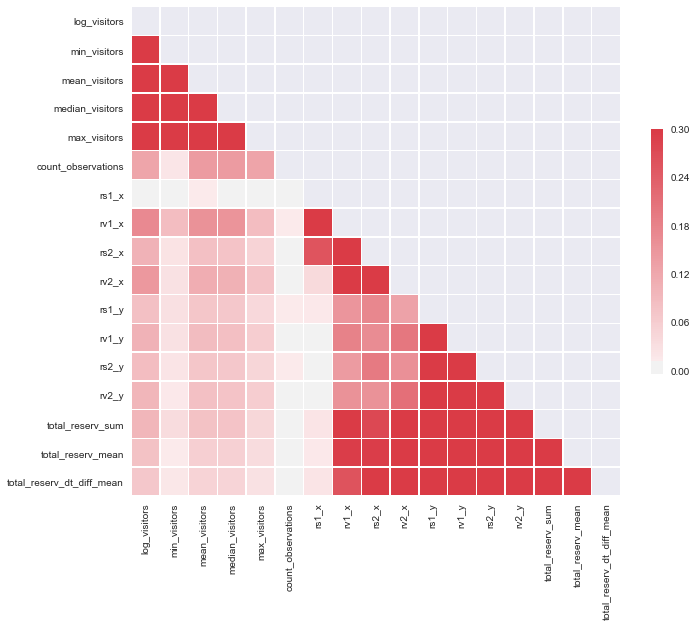

In [14]:
corr = train[subset].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

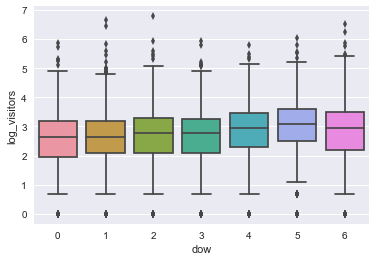

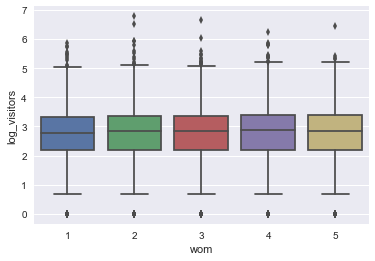

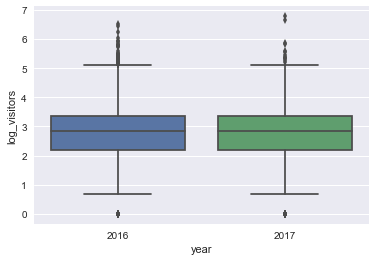

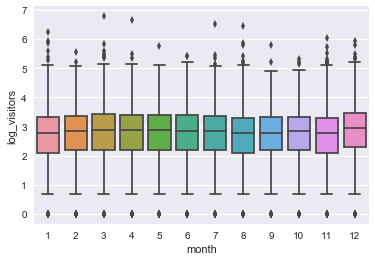

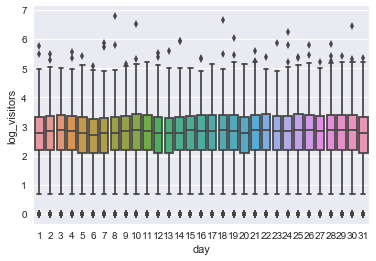

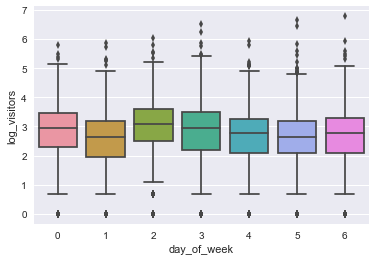

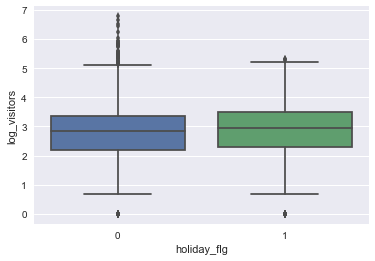

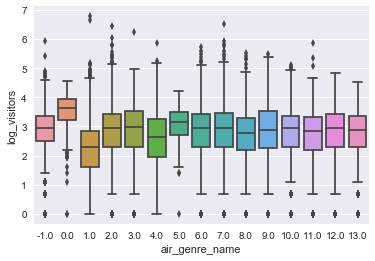

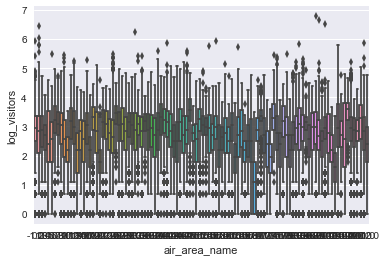

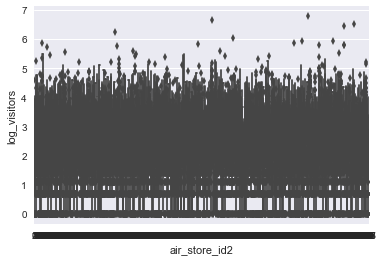

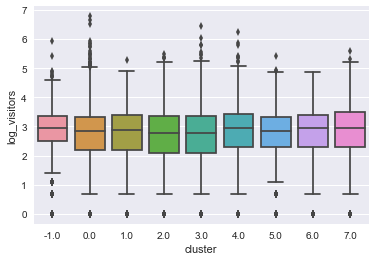

In [15]:
for i, cat in enumerate(categorical_vars):
    plt.figure(i)
    sns.boxplot(x=cat, y=targets[1], data=train)

In [16]:
y = train[targets[1]]
X = train[numeric_vars]

lm = sm.OLS(y, X).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:           log_visitors   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.031e+05
Date:                Mon, 05 Feb 2018   Prob (F-statistic):               0.00
Time:                        20:08:34   Log-Likelihood:            -2.9045e+05
No. Observations:              252108   AIC:                         5.809e+05
Df Residuals:                  252092   BIC:                         5.811e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
min_visitors          

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [18]:
vif.round(1)

,VIF Factor,features
0,4.0,min_visitors
1,263.5,mean_visitors
2,205.8,median_visitors
3,6.6,max_visitors
4,5.1,count_observations
5,2.0,rs1_x
6,3.9,rv1_x
7,2.2,rs2_x
8,3.5,rv2_x
9,4.4,rs1_y


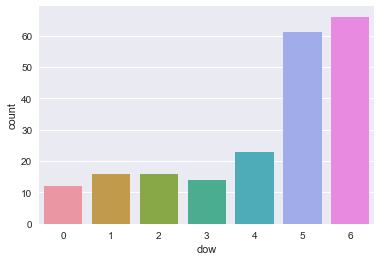

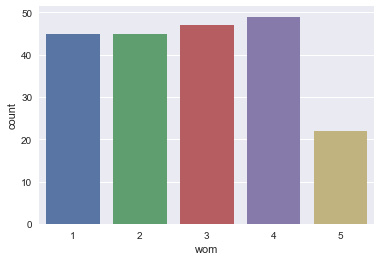

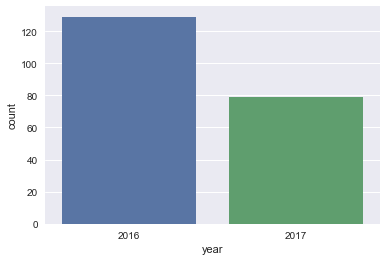

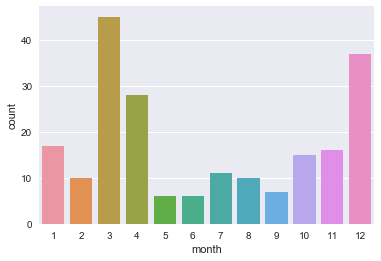

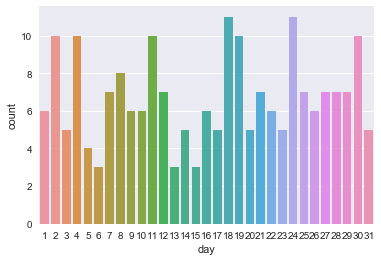

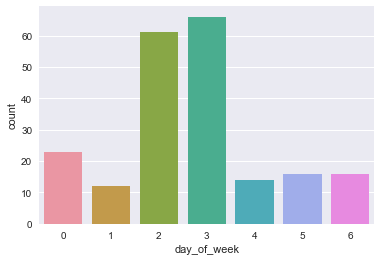

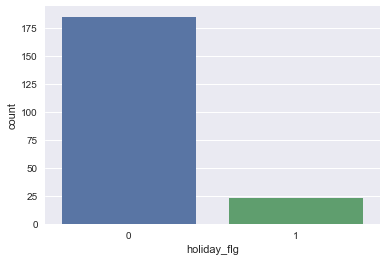

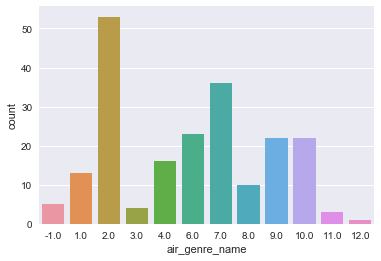

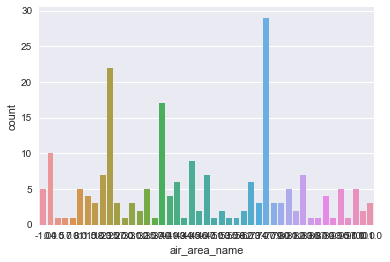

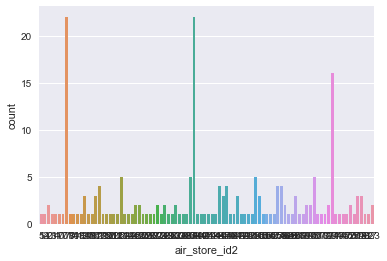

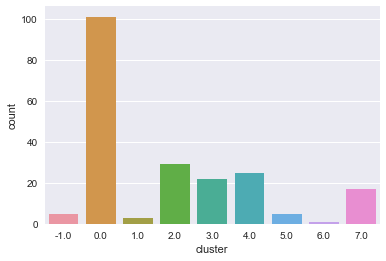

In [19]:
train['large_party'] = np.where(train['visitors'] >= 120, 1., 0.)
for cat in categorical_vars:
    plt.figure()
    sns.countplot(x=cat, data=train.loc[train['large_party']==1.])

In [20]:
from sklearn.linear_model import LogisticRegression
y = train['large_party']
X = train[numeric_vars + categorical_vars]

lr = sm.Logit(y, X)
model = lr.fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.004233
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:            large_party   No. Observations:               252108
Model:                          Logit   Df Residuals:                   252081
Method:                           MLE   Df Model:                           26
Date:                Mon, 05 Feb 2018   Pseudo R-squ.:                  0.3665
Time:                        20:08:40   Log-Likelihood:                -1067.2
converged:                       True   LL-Null:                       -1684.7
                                        LLR p-value:                4.198e-244
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
min_visitors                 -0.0186      0.005     -3.575      0.000      -0

In [51]:
reserve_vars = ['rs1_x', 'rv1_x', 'rs2_x', 'rv2_x', 'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y']
y = train[reserve_vars[7]]
X = train[numeric_vars + categorical_vars].drop(reserve_vars, axis=1)

rfr = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
model = rfr.fit(X, y)
print(mean_squared_error(y, model.predict(X)))

0.203628114942


In [19]:
tmp1 = train.copy()
tmp1['data_set'] = 'Train'
tmp2 = test.copy()
tmp2['data_set'] = 'Test'
combined = pd.concat([tmp1, tmp2])
del(tmp1)
del(tmp2)

D:\Users\Luis\Programs\Anaconda3\envs\PREDICT-env\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


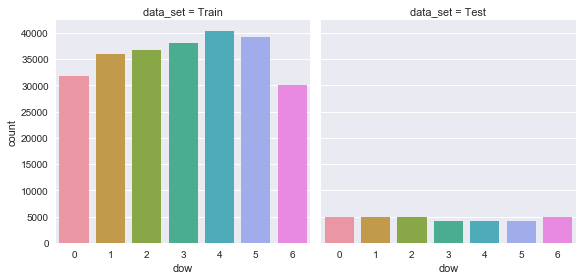

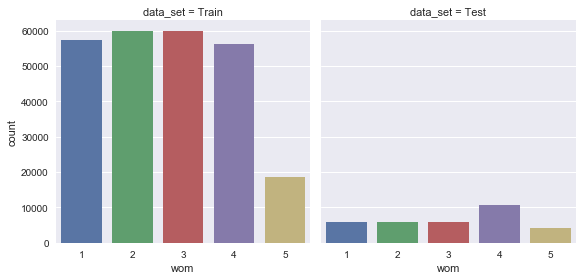

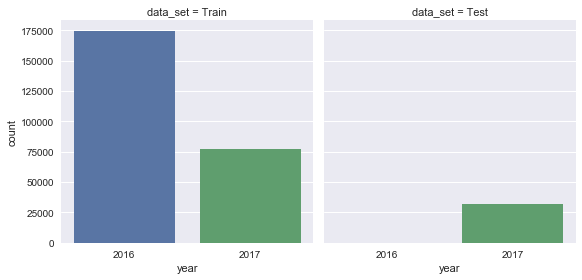

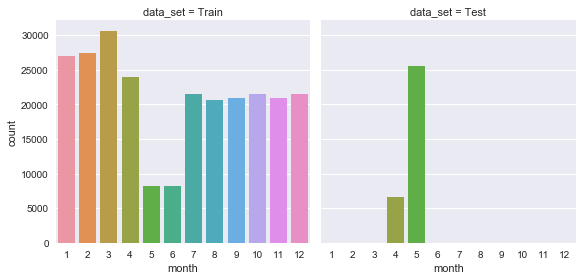

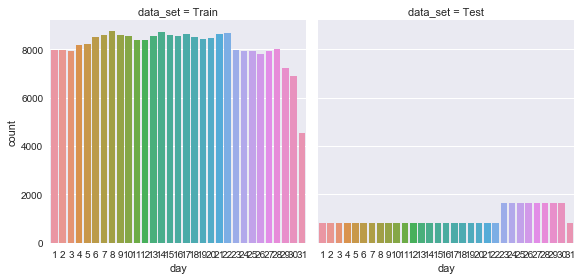

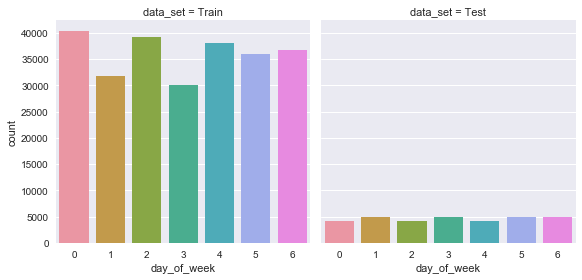

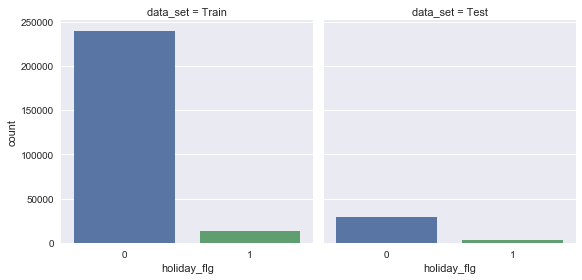

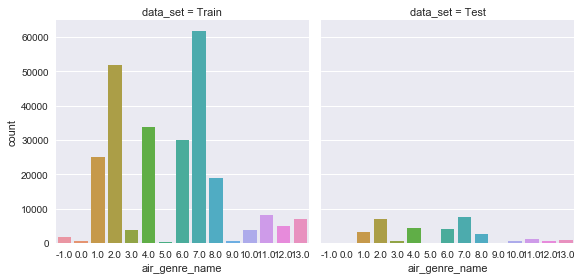

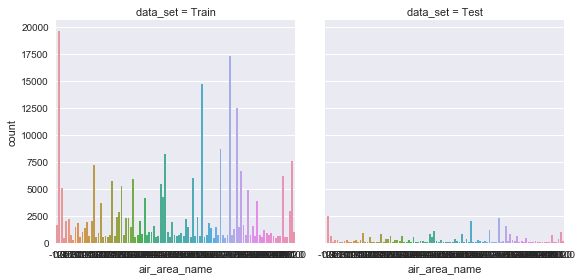

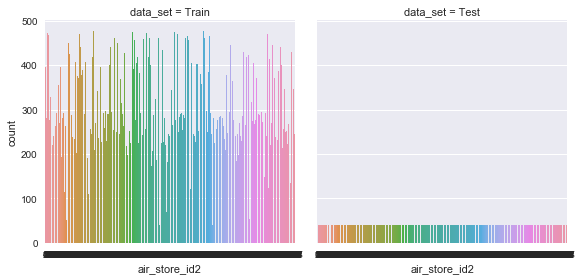

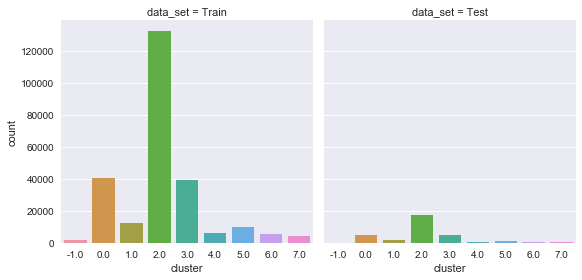

In [20]:
for cat in categorical_vars:
    plt.figure()
    sns.factorplot(x=cat, col='data_set', data=combined, kind="count")

D:\Users\Luis\Programs\Anaconda3\envs\PREDICT-env\lib\site-packages\mpl_toolkits\basemap\__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
D:\Users\Luis\Programs\Anaconda3\envs\PREDICT-env\lib\site-packages\mpl_toolkits\basemap\__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
No handlers could be found for logger "matplotlib.legend"


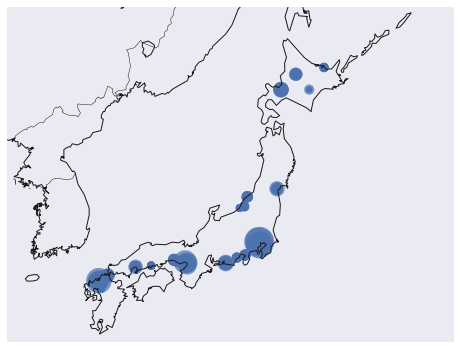

In [21]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='aea',
            lat_0=39., 
            lon_0=138.,
            resolution ='l',
            width=2.4E6, height=1.8E6)
m.drawcoastlines()
m.drawcountries()
# m.shadedrelief()
m.scatter(train.longitude.values, train.latitude.values, latlon=True,
          s=train.visitors.values,
          cmap='Reds', alpha=0.7)
plt.legend()

In [22]:
ts = pd.DataFrame(train[['visit_date', 'air_area_name', 'air_genre_name', 
                         'cluster', 'day_of_week', 'holiday_flg', 'visitors', 'visitor_diff', 'log_visitors', 'log_visitor_diff']])
ts = ts.set_index('visit_date')
ts.index = ts.index.to_datetime()
ts.index.name = 'visit_date'

D:\Users\Luis\Programs\Anaconda3\envs\PREDICT-env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  after removing the cwd from sys.path.


In [23]:
ts = ts.sort_index()

In [24]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, label):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=14)
    rolstd = pd.rolling_std(timeseries, window=14)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[label], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

D:\Users\Luis\Programs\Anaconda3\envs\PREDICT-env\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=14,center=False).mean()
  
D:\Users\Luis\Programs\Anaconda3\envs\PREDICT-env\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=14,center=False).std()
  import sys


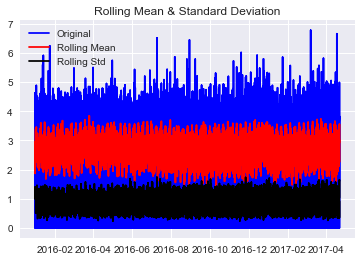

Results of Dickey-Fuller Test:
Test Statistic                    -25.220199
p-value                             0.000000
#Lags Used                         86.000000
Number of Observations Used    252021.000000
Critical Value (5%)                -2.861551
Critical Value (1%)                -3.430376
Critical Value (10%)               -2.566776
dtype: float64


In [25]:
test_stationarity(ts[['log_visitors']], 'log_visitors')

D:\Users\Luis\Programs\Anaconda3\envs\PREDICT-env\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=14,center=False).mean()
  
D:\Users\Luis\Programs\Anaconda3\envs\PREDICT-env\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=14,center=False).std()
  import sys


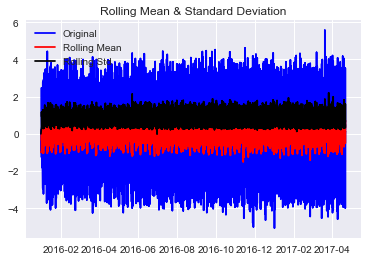

Results of Dickey-Fuller Test:
Test Statistic                    -24.748990
p-value                             0.000000
#Lags Used                         86.000000
Number of Observations Used    252021.000000
Critical Value (5%)                -2.861551
Critical Value (1%)                -3.430376
Critical Value (10%)               -2.566776
dtype: float64


In [26]:
test_stationarity(ts[['log_visitor_diff']], 'log_visitor_diff')

In [27]:
for i in range(1, 26):
    print("KPSS test for lag = ", i, kpss(ts.log_visitors, lags=i))

('KPSS test for lag = ', 1, (8.6720488262110909, 0.01, 1, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 2, (8.3147809286560808, 0.01, 2, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))


D:\Users\Luis\Programs\Anaconda3\envs\PREDICT-env\lib\site-packages\statsmodels\tsa\stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


('KPSS test for lag = ', 3, (7.9878119511035459, 0.01, 3, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 4, (7.6866151509228198, 0.01, 4, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 5, (7.4062813161640975, 0.01, 5, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 6, (7.1469053683833499, 0.01, 6, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 7, (6.9038753246583981, 0.01, 7, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 8, (6.6780087195436417, 0.01, 8, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 9, (6.4630279021480597, 0.01, 9, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 10, (6.2608973569324009, 0.01, 10, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 11, (6.0711272717415916, 0.01, 11, {'5%': 0.4

In [28]:
for i in range(1, 26):
    print("KPSS test for lag = ", i, kpss(ts.log_visitor_diff, lags=i))

('KPSS test for lag = ', 1, (1.2323926574599919, 0.01, 1, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 2, (1.1741117067689826, 0.01, 2, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 3, (1.1199066675942211, 0.01, 3, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 4, (1.0706759136625952, 0.01, 4, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 5, (1.0258682272417126, 0.01, 5, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 6, (0.98454992060447233, 0.01, 6, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 7, (0.94641878381957234, 0.01, 7, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 8, (0.91120943105899088, 0.01, 8, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}))
('KPSS test for lag = ', 9, (0.87877992198356514, 0.01, 9, {'5%': 0.4

In [29]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(ts.log_visitors, lags=25)

(array([   474.14233911,    997.5310663 ,   1491.32448964,   1982.73803425,
          2490.86266973,   2974.37230014,   3490.67707121,   3967.53217108,
          4549.25433076,   5077.62665564,   5589.29825745,   6078.23172729,
          6529.4739591 ,   7050.52628168,   7547.52398222,   8095.41231877,
          8474.86626229,   8965.87901622,   9481.81639524,   9965.27477977,
         10492.94428036,  10920.94788362,  11456.55645212,  11963.17244965,
         12435.96427156]),
 array([  4.02136746e-105,   2.44839334e-217,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+00

In [30]:
acorr_ljungbox(ts.log_visitor_diff, lags=25)

(array([   671.45964743,   1366.24423985,   2119.25470177,   2824.45725141,
          3511.0928553 ,   4229.63881069,   4940.19322478,   5634.69061563,
          6284.8155274 ,   6990.72599261,   7648.38814739,   8284.28496581,
          8907.53400675,   9579.02961781,  10193.51273681,  10854.35167592,
         11442.5203642 ,  11977.93118538,  12562.82844689,  13178.1465048 ,
         13840.69411465,  14466.96269485,  15029.69978725,  15616.7543567 ,
         16274.6955382 ]),
 array([  4.81034087e-148,   2.10781675e-297,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+00

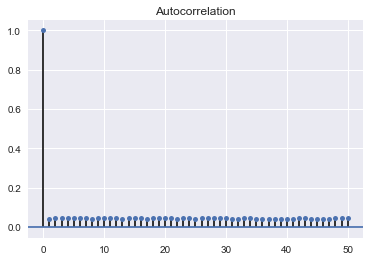

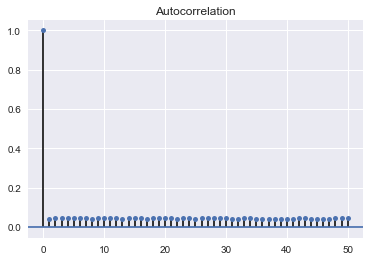

In [31]:
plot_acf(ts.log_visitors, lags=50)

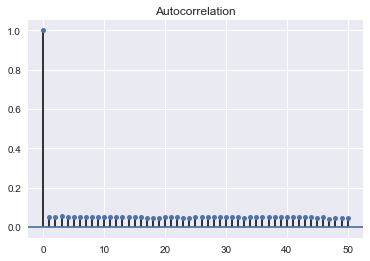

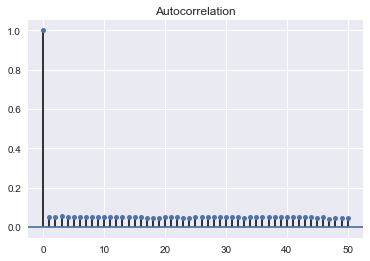

In [32]:
plot_acf(ts.log_visitor_diff, lags=50)

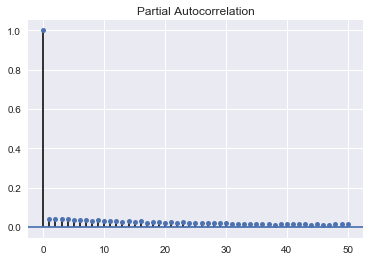

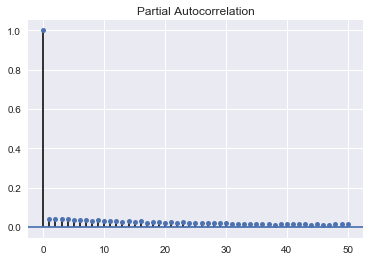

In [33]:
plot_pacf(ts.log_visitors, lags=50)

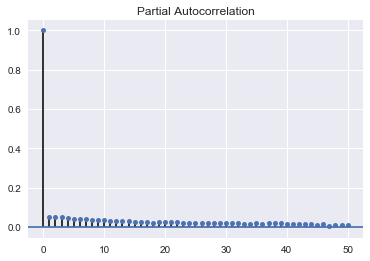

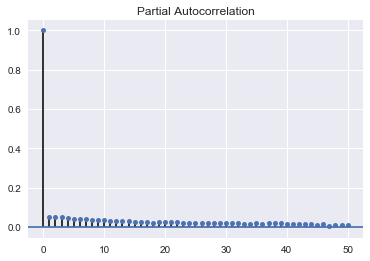

In [34]:
plot_pacf(ts.log_visitor_diff, lags=50)

In [49]:
print(model.params)

min_visitors                -0.014056
mean_visitors                0.169770
median_visitors             -0.090371
max_visitors                 0.004565
count_observations          -0.033284
rs1_x                       -0.000663
rv1_x                        0.013962
rs2_x                        0.009095
rv2_x                        0.021558
rs1_y                       -0.078520
rv1_y                        0.075190
rs2_y                        0.101037
rv2_y                       -0.036189
total_reserv_sum             0.009238
total_reserv_mean           -0.053849
total_reserv_dt_diff_mean   -0.004943
dow                          0.120783
wom                          0.094877
year                        -0.004346
month                        0.023464
day                          0.001311
day_of_week                  0.035679
holiday_flg                  1.079857
air_genre_name              -0.083195
air_area_name               -0.004103
air_store_id2               -0.000215
cluster     